<a href="https://colab.research.google.com/github/Jeong2357/MLSC-Coding/blob/main/Question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

**Question 2.**

* We have a priori bang-bang assumption.
* We only know **the governing equation** of the pendulum.
* We do not know how to minimize the stopping time.
* We know machine learning.


Q. Do the same as in **Question 1**, except that you must simulate the behavior of the pendulum by Runge-Kutta 4 method.



In [6]:
#Basic Settings
g = 9.8
L = float(input("The length of string of the pendulum (unit : m) = "))

#-----------------------------
#ODE Solver
#-----------------------------

def derivative(t, state, u):
    """ external force = u , state = [theta, omega] --> find theta', omega'"""

    theta = state[0]  # 현재 각도
    omega = state[1]  # 현재 각속도

    # 1. 각도는 각속도만큼 변합니다
    d_theta = omega

    # 2. 각속도는 힘(가속도)만큼 변합니다
    d_omega = -g/L * np.sin(theta) + u

    return np.array([d_theta, d_omega])

def rk4_step(t, state, u, dt):
    k1 = derivative(t, state, u)
    k2 = derivative(t+dt/2, state + k1 * dt / 2, u)
    k3 = derivative(t+dt/2, state + k2 * dt / 2, u)
    k4 = derivative(t+dt, state + k3 * dt, u )
    next_state = state + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return next_state



#-----------------------------
#Environment
#-----------------------------
class Pendulumdynamics:
    def __init__(self, dt=0.05):
        self.dt = dt
        self.max_steps = 400 # 20초(400 * 0.05) 지나면 강제 종료
        self.reset()

    def reset(self):
        # 초기 상태를 랜덤하게! (스위칭 곡선을 배우기 위함)
        self.theta = random.uniform(-1.5, 1.5)
        self.theta_0 = self.theta
        self.omega = random.uniform(-1.5, 1.5)
        self.omega_0 = self.omega
        self.step_count = 0
        return np.array([self.theta, self.omega], dtype=np.float32)

    # (테스트용) 고정된 위치에서 시작하고 싶을 때 사용
    def reset_fixed(self, theta, omega):
        self.theta = theta
        self.omega = omega
        self.step_count = 0
        return np.array([self.theta, self.omega], dtype=np.float32)

    def step_forward(self, action):
        # action: 0 -> -1, 1 -> +1
        u = 2 * action - 1

        # 물리 엔진 (RK4)
        current_state = np.array([self.theta, self.omega])
        next_state = rk4_step(0, current_state, u, self.dt)

        self.theta, self.omega = next_state
        self.step_count += 1

        # 상태 벡터
        state = np.array([self.theta, self.omega], dtype=np.float32)

        # 종료 조건
        # 1. 성공: 원점 근처 정지
        success = np.linalg.norm(state) < 0.01
        # 2. 실패: 너무 멀리 날아감 (학습 효율을 위해 중요)
        out_of_bound = abs(self.theta) > max(12, 1.5 * abs(self.theta_0)) or abs(self.omega) > max(8, 1.5 * abs(self.omega_0))
        # 3. 시간 초과
        timeout = self.step_count >= self.max_steps

        done = success or out_of_bound or timeout

        # 보상 설계 (Reward Shaping)
        reward = -0.1 # 매 시간마다 감점 (빨리 끝내라)

        if success:
            reward += 1000.0 # 성공 보상 팍팍!
        elif out_of_bound:
            reward -= 100.0 # 맵 밖으로 나가면 벌점

        return state, reward, done, u

#-----------------------------
#Networks
#-----------------------------
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)


#-----------------------------
#Training
#-----------------------------
# ---------------------------------------------------------
# 3. 학습 루프 (안정화)
# ---------------------------------------------------------
def train(num_episodes=2000):
    env = Pendulumdynamics(dt=0.05)
    policy = PolicyNetwork()
    optimizer = optim.Adam(policy.parameters(), lr=0.001)

    score_history = []

    print(f"학습 시작 (총 {num_episodes} 에피소드)...")

    for epi in range(num_episodes):
        state = env.reset() # 랜덤 위치 시작
        log_probs = []
        rewards = []

        while True:
            state_tensor = torch.FloatTensor(state)
            probs = policy(state_tensor)

            # 확률 분포대로 샘플링 (탐색)
            m = torch.distributions.Categorical(probs)
            action = m.sample()

            next_state, reward, done, _ = env.step_forward(action.item())

            log_probs.append(m.log_prob(action))
            rewards.append(reward)
            state = next_state

            if done: break

        # --- REINFORCE 알고리즘 업데이트 ---
        R = 0
        returns = []
        # 뒤에서부터 보상 누적 (Discounted Return)
        for r in rewards[::-1]:
            R = r + 0.99 * R
            returns.insert(0, R)

        returns = torch.tensor(returns)
        # 보상 정규화 (학습 안정화 필수 테크닉)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        loss = []
        for log_prob, R in zip(log_probs, returns):
            loss.append(-log_prob * R)

        optimizer.zero_grad()
        sum(loss).backward()
        optimizer.step()

        score_history.append(sum(rewards))

        if epi % 100 == 0:
            print(f"Epi {epi} | Avg Score: {np.mean(score_history[-50:]):.2f}")

    return policy

# ==========================================
# 실행부 (Main)
# ==========================================
if __name__ == "__main__":
    trained_policy = train(num_episodes=2000)
    torch.save(trained_policy.state_dict(), "magician_brain.pth")

The length of string of the pendulum (unit : cm) = 0.5
학습 시작 (총 2000 에피소드)...
Epi 0 | Avg Score: -40.00
Epi 100 | Avg Score: -19.50
Epi 200 | Avg Score: -19.97
Epi 300 | Avg Score: 40.98
Epi 400 | Avg Score: 243.35
Epi 500 | Avg Score: 202.46
Epi 600 | Avg Score: 364.45
Epi 700 | Avg Score: 712.37
Epi 800 | Avg Score: 796.61
Epi 900 | Avg Score: 879.07
Epi 1000 | Avg Score: 962.70
Epi 1100 | Avg Score: 985.63
Epi 1200 | Avg Score: 986.81
Epi 1300 | Avg Score: 986.44
Epi 1400 | Avg Score: 984.74
Epi 1500 | Avg Score: 986.00
Epi 1600 | Avg Score: 986.66
Epi 1700 | Avg Score: 985.78
Epi 1800 | Avg Score: 987.10
Epi 1900 | Avg Score: 987.63


성공적으로 마법사의 뇌를 불러왔습니다!

--- 펜듈럼 제어 시뮬레이션 ---
초기 각도(rad) 입력 (예: 3.14): 1.0
초기 각속도(rad/s) 입력 (예: 0): -0.2
🎬 Simulation Start: Theta=1.0, Omega=-0.2
🛑 Simulation Ended at 8.30s (Success/Fail/Timeout)


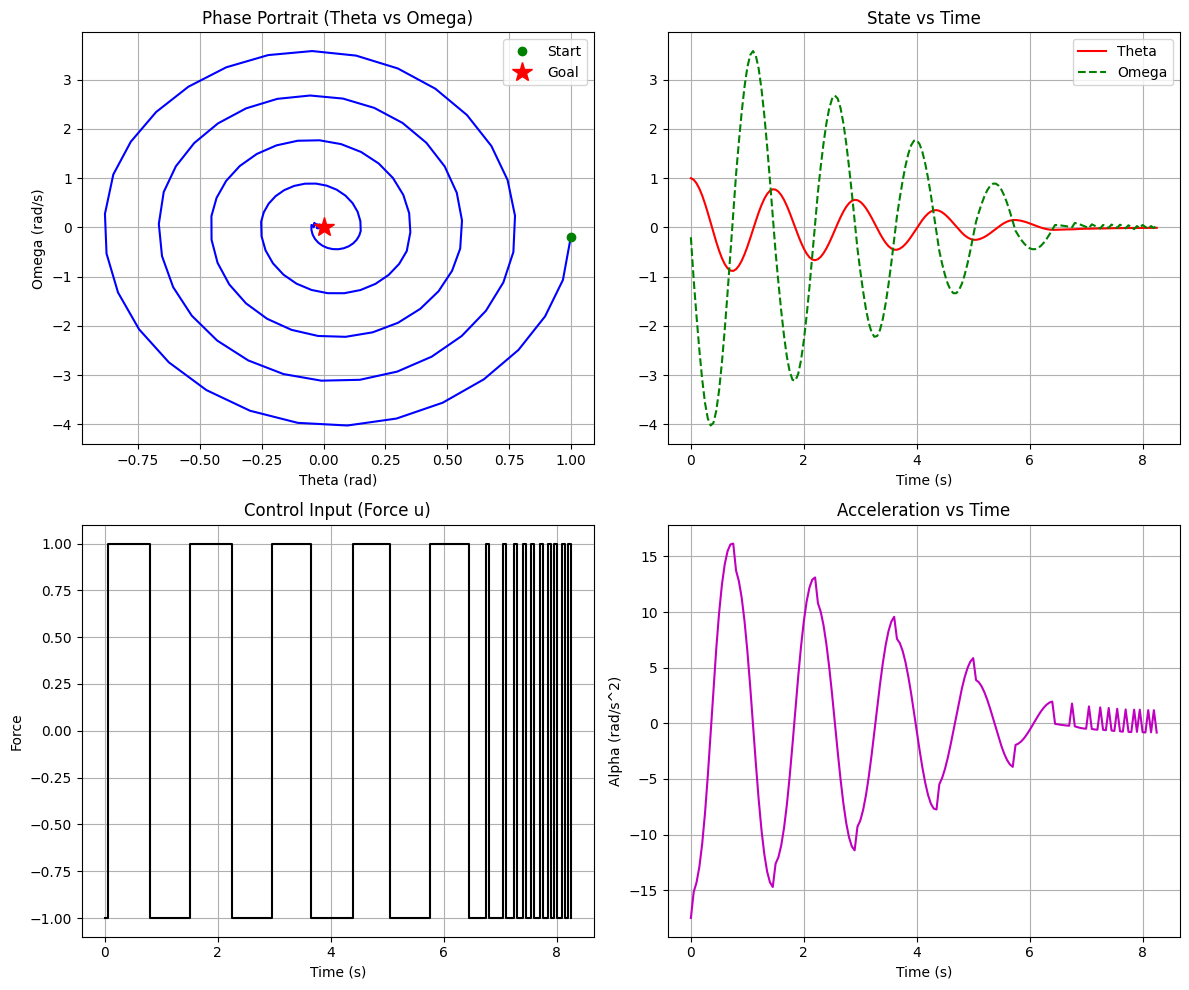

In [19]:
def simulate_and_plot(policy, init_theta, init_omega):
    """
    학습된 policy를 이용하여, 지정된 초기 상태에서부터의 궤적을 시뮬레이션하고 그립니다.
    """
    # 1. 환경 및 초기화
    # 테스트용이므로 최대 스텝을 넉넉하게 잡습니다.
    env = Pendulumdynamics(dt=0.05)
    env.reset() # 일단 초기화 (메모리 할당)

    # 2. 초기 상태 강제 설정 (사용자 입력값)
    env.theta = init_theta
    env.omega = init_omega
    # 상태 벡터 업데이트
    env.state = np.array([env.theta, env.omega], dtype=np.float32)

    # 기록용 리스트 (History)
    history = {
        'time': [],
        'theta': [],
        'omega': [],
        'action': [], # Control Input (u)
        'accel': []   # Acceleration (theta_ddot)
    }

    # 3. 시뮬레이션 루프 (Inference Loop)
    state = env.state
    time = 0.0

    print(f"🎬 Simulation Start: Theta={init_theta}, Omega={init_omega}")

    with torch.no_grad(): # 테스트니깐 미분값 계산 끔 (메모리 절약)
        while True:
            # (1) 관찰
            state_tensor = torch.FloatTensor(state)

            # (2) 정책망의 판단
            probs = policy(state_tensor)

            # (3) 행동 선택 (Greedy: 확률이 가장 높은 행동 선택)
            # 학습 때는 sample()을 썼지만, 실전에서는 가장 자신 있는 행동을 합니다.
            action_idx = torch.argmax(probs).item()

            # (4) 물리 엔진 실행
            next_state, reward, done, u_val = env.step_forward(action_idx)

            # (5) 가속도 계산 (그래프용, 운동방정식 역산)
            # theta'' = -g/L sin(theta) + u
            # 주의: L은 전역변수 혹은 env 내부 변수 사용. 여기선 전역변수 L 가정
            accel = -(g/L) * np.sin(state[0]) + u_val

            # (6) 기록
            history['time'].append(time)
            history['theta'].append(state[0])
            history['omega'].append(state[1])
            history['action'].append(u_val)
            history['accel'].append(accel)

            state = next_state
            time += env.dt

            # 종료 조건
            if done:
                print(f"🛑 Simulation Ended at {time:.2f}s (Success/Fail/Timeout)")
                break

    # 4. 그래프 그리기 (Visualization)
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # [좌상단] Phase Portrait (위상 평면)
    axs[0, 0].plot(history['theta'], history['omega'], 'b-')
    axs[0, 0].plot(history['theta'][0], history['omega'][0], 'go', label='Start')
    axs[0, 0].plot(0, 0, 'r*', markersize=15, label='Goal')
    axs[0, 0].set_title('Phase Portrait (Theta vs Omega)')
    axs[0, 0].set_xlabel('Theta (rad)')
    axs[0, 0].set_ylabel('Omega (rad/s)')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # [우상단] Position & Velocity vs Time
    axs[0, 1].plot(history['time'], history['theta'], 'r-', label='Theta')
    axs[0, 1].plot(history['time'], history['omega'], 'g--', label='Omega')
    axs[0, 1].set_title('State vs Time')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # [좌하단] Control Input (Bang-Bang)
    axs[1, 0].step(history['time'], history['action'], where='post', color='k')
    axs[1, 0].set_title('Control Input (Force u)')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Force')
    axs[1, 0].grid(True)

    # [우하단] Acceleration vs Time
    axs[1, 1].plot(history['time'], history['accel'], 'm-')
    axs[1, 1].set_title('Acceleration vs Time')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('Alpha (rad/s^2)')
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def load_and_test_magician():
    # 1. 껍데기(모델 구조) 만들기
    # 주의: 학습할 때 썼던 모델 구조(레이어 크기 등)와 똑같아야 합니다.
    magician = PolicyNetwork()

    # 2. 기억(가중치) 주입하기
    try:
        magician.load_state_dict(torch.load("magician_brain.pth"))
        magician.eval() # [중요] "지금은 학습 모드가 아니라 평가 모드야"라고 선언
        print("성공적으로 마법사의 뇌를 불러왔습니다!")
    except FileNotFoundError:
        print("저장된 파일이 없습니다. 먼저 학습(train)을 실행하세요.")
        return

    # 3. 사용자 입력 받기 (원하는 초기값)
    print("\n--- 펜듈럼 제어 시뮬레이션 ---")
    try:
        init_theta = float(input("초기 각도(rad) 입력 (예: 3.14): "))
        init_omega = float(input("초기 각속도(rad/s) 입력 (예: 0): "))
    except ValueError:
        print("숫자만 입력해주세요.")
        return

    # 4. 시뮬레이션 함수 호출 (이전에 만든 그 함수)
    # 이제 'magician'은 학습된 지능을 가지고 있습니다.
    simulate_and_plot(magician, init_theta, init_omega)

# --- 실행 ---
if __name__ == "__main__":
    load_and_test_magician()

In [10]:
pip install pandas

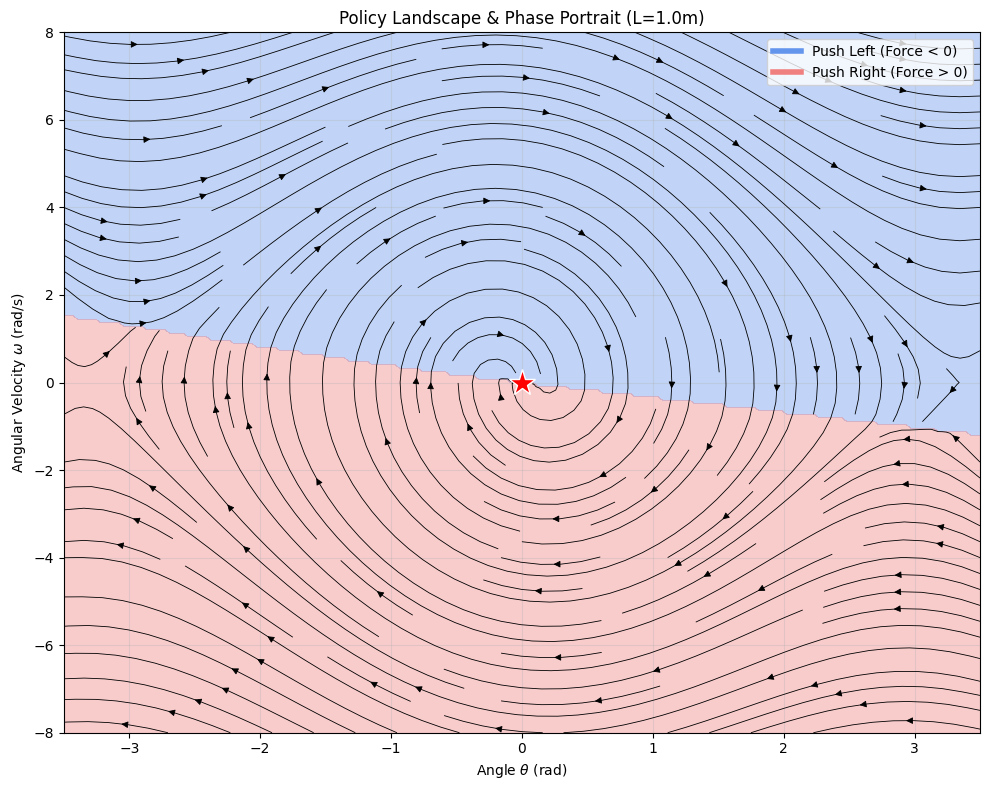

In [11]:

def plot_policy_landscape(policy, L=1.0):
    # 1. 그리드 생성 (넓은 범위 설정)
    # 각도(theta): -3.5 ~ 3.5 라디안 (한 바퀴 조금 넘는 범위)
    # 각속도(omega): -8.0 ~ 8.0 라디안/초
    theta_range = np.linspace(-3.5, 3.5, 200)
    omega_range = np.linspace(-8.0, 8.0, 200)
    Theta, Omega = np.meshgrid(theta_range, omega_range)

    # 2. 모델 예측을 위한 텐서 변환
    # (H, W, 2) 형태로 만들고 평탄화하여 배치 처럼 만듦
    grid_tensor = torch.FloatTensor(np.stack([Theta, Omega], axis=-1)).reshape(-1, 2)

    policy.eval() # 평가 모드 전환
    with torch.no_grad():
        probs = policy(grid_tensor)
        # 확률이 높은 쪽의 인덱스를 가져옴 (0 또는 1)
        actions = torch.argmax(probs, dim=1).numpy()

    # 다시 그리드 형태로 복원
    Action_Map = actions.reshape(Theta.shape)

    # 3. 물리 역학 흐름 계산 (Streamplot용)
    # Action 0 -> Force -2.0 (왼쪽)
    # Action 1 -> Force +2.0 (오른쪽)
    Force_Map = (2 * Action_Map - 1) * 2.0

    g = 9.8
    # d(theta)/dt = omega
    U_vel = Omega
    # d(omega)/dt = -(g/L)sin(theta) + u
    V_acc = -(g / L) * np.sin(Theta) + Force_Map

    # -----------------------------
    # 4. 그래프 그리기
    # -----------------------------
    plt.figure(figsize=(10, 8))

    # (1) 배경: AI의 행동 결정 (Contourf)
    # 파란색 영역: 왼쪽으로 힘을 가함 / 빨간색 영역: 오른쪽으로 힘을 가함
    plt.contourf(Theta, Omega, Action_Map, levels=[-0.5, 0.5, 1.5],
                 colors=['cornflowerblue', 'lightcoral'], alpha=0.4)

    # (2) 흐름선: 펜듈럼의 움직임 (Streamplot)
    strm = plt.streamplot(Theta, Omega, U_vel, V_acc, color='k', linewidth=0.6, density=1.5, arrowsize=1.0)

    # (3) 목표 지점 및 장식
    plt.plot(0, 0, 'r*', markersize=20, label='Goal (0,0)', markeredgecolor='white')

    # 범례 생성을 위한 더미 플롯
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='cornflowerblue', lw=4),
                    Line2D([0], [0], color='lightcoral', lw=4)]

    plt.legend(custom_lines, ['Push Left (Force < 0)', 'Push Right (Force > 0)'], loc='upper right')

    plt.title(f'Policy Landscape & Phase Portrait (L={L}m)')
    plt.xlabel(r'Angle $\theta$ (rad)')
    plt.ylabel(r'Angular Velocity $\omega$ (rad/s)')
    plt.xlim([-3.5, 3.5])
    plt.ylim([-8, 8])
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# -----------------------------
# 실행 코드
# -----------------------------
# 위에서 학습된 trained_policy가 메모리에 있다면 바로 실행 가능합니다.
if 'trained_policy' in locals():
    plot_policy_landscape(trained_policy, L=1.0)
else:
    print("먼저 trained_policy 모델을 학습시켜주세요.")